
# Stacked Regressions to predict House Prices 


## Serigne

**July 2017**

**If you use parts of this notebook in your scripts/notebooks, giving  some kind of credit would be very much appreciated :)  You can for instance link back to this notebook. Thanks!**

This competition is very important to me as  it helped me to begin my journey on Kaggle few months ago. I red  some great notebooks here. To name a few:

1. [Comprehensive data exploration with Python][1] by **Pedro Marcelino**  : Great and very motivational data analysis

2. [A study on Regression applied to the Ames dataset][2] by **Julien Cohen-Solal**  : Thorough features engeneering but really easy to follow for beginners.

3. [Regularized Linear Models][3] by **Alexandru Papiu**  : Great Starter kernel on modelling and Cross-validation

I can't recommend enough every beginner to go carefully through these kernels (and of course through many others great kernels) and get their first insights in data science and kaggle competitions.

After that (and some basic pratices) you should be more confident to go through [this great script][7] by **Human Analog**  who did an impressive work on features engeneering. 

As the dataset is particularly handy, I  decided few days ago to get back in this competition and apply things I learnt so far, especially stacking models.  The approach used here is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  [XGBoost][5] and [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso

To my surprise, this does well on LB ( 0.11420 and top 4% the last time I tested it : **July 2, 2017** )

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability

from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output


In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('c:/Users/HP/Desktop/HousePrice//train.csv')
test = pd.read_csv('c:/Users/HP/Desktop/HousePrice///test.csv')


In [3]:
test.shape

(1459, 80)

In [4]:
test.Id.values

array([1461, 1462, 1463, ..., 2917, 2918, 2919], dtype=int64)

In [5]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test.shape

(1459, 80)

In [7]:
##display the first five rows of the test dataset.
test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#Data Processing

##Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


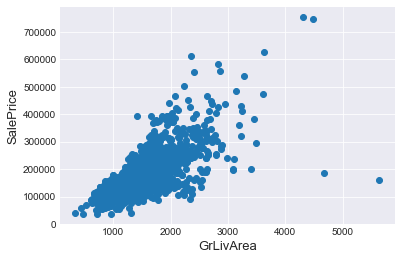

In [8]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

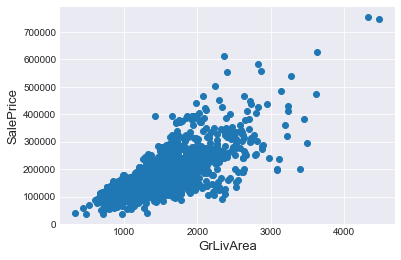

In [9]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Note : 
 Outliers removal is not always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

##Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180932.92 and sigma = 79467.79



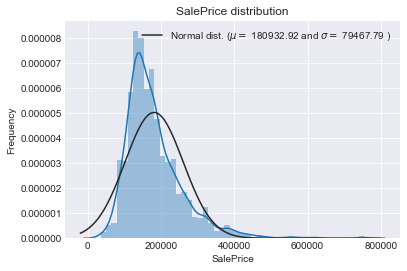

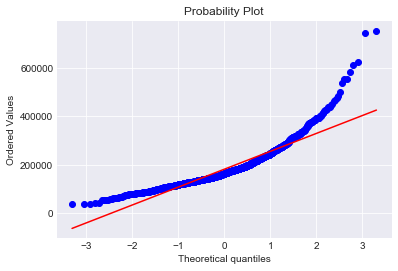

In [10]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

 **Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



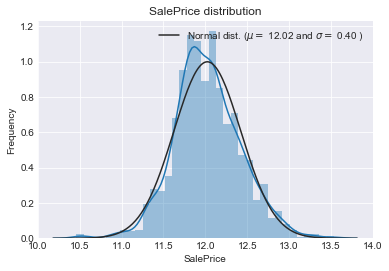

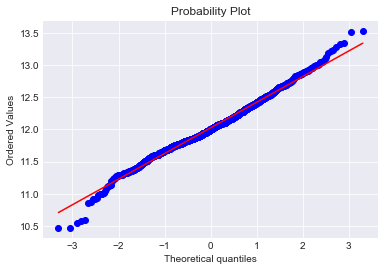

In [11]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

## Features engineering

let's first  concatenate the train and test data in the same dataframe

In [12]:
test.shape

(1459, 80)

In [13]:
train.shape

(1458, 81)

In [14]:
train.Id.values

array([   1,    2,    3, ..., 1458, 1459, 1460], dtype=int64)

In [15]:
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.000,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.073
1456,1457,20,RL,85.000,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.255
1457,1458,70,RL,66.000,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493
1458,1459,20,RL,68.000,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864
1459,1460,20,RL,75.000,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,11.902


In [16]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [17]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 80)


In [18]:
ntest

1459

### Missing Data

In [19]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


In [20]:
all_data.isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            2719
BedroomAbvGr        0
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2346
FireplaceQu      1420
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LotFrontage       486
LotShape            0
LowQualFinSF        0
MSSubClass          0
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2812
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive

Text(0.5,1,'Percent missing data by feature')

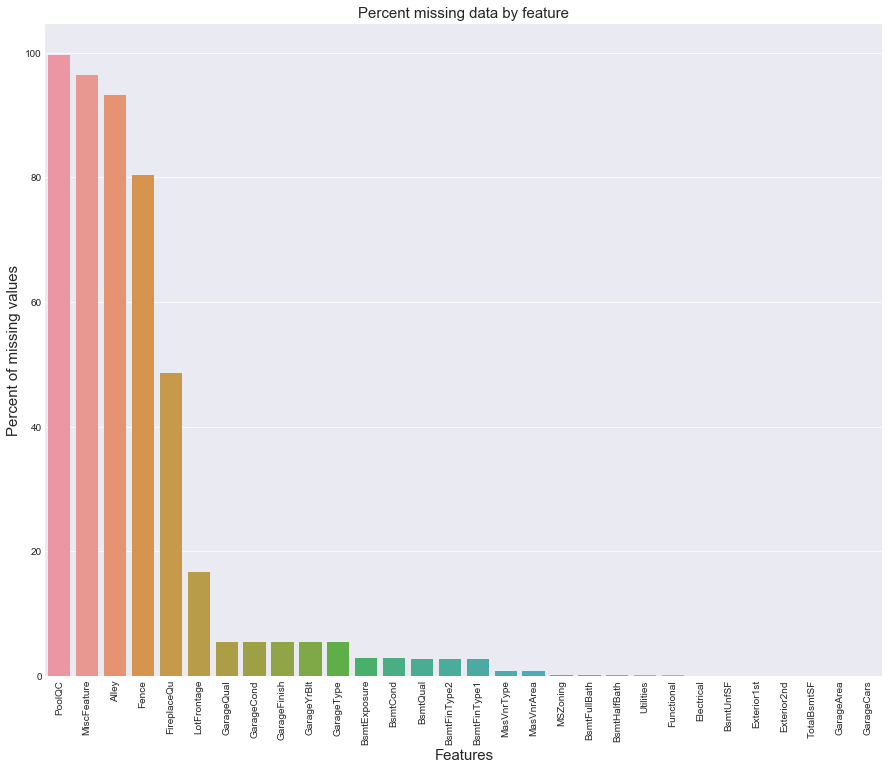

In [21]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


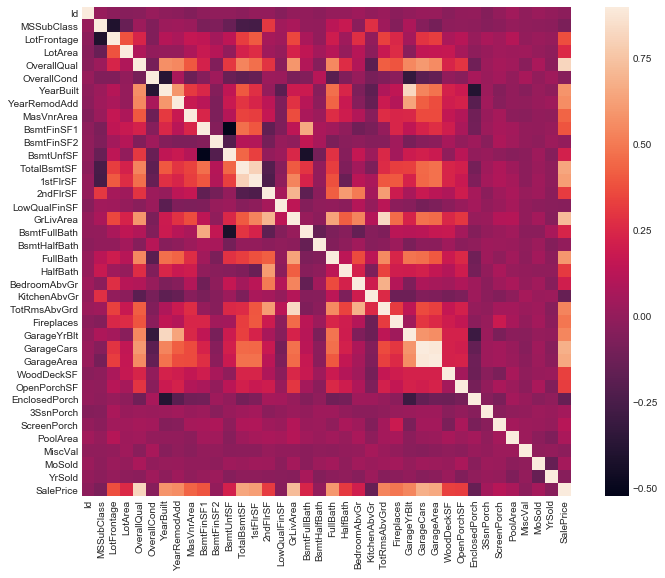

In [22]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool"

In [23]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : data description says NA means "no misc feature"


In [24]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [25]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [26]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [27]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [28]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [29]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [30]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [31]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there isn't a basement.


In [32]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [33]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [34]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [35]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [36]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [37]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [38]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [39]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [40]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [41]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



Is there any remaining missing value ? 

In [42]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.


### More features engeneering

**Transforming some numerical variables that are really categorical**

In [43]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)



In [44]:
all_data.shape

(2917, 79)

**Label Encoding some categorical variables that may contain information in their ordering set** 

In [45]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))




Shape all_data: (2917, 79)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [46]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Skewed features**

In [47]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [48]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 60 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [49]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 221)


Getting the new train and test sets. 

In [50]:
ntrain

1458

In [51]:
ntrain = train.shape[0]
ntest = test.shape[0]


In [52]:
train = all_data[:train.shape[0]]
test = all_data[test.shape[0]:]


In [53]:
train.Id

0       1.730
1       2.194
2       2.541
3       2.820
4       3.056
5       3.260
6       3.440
7       3.603
8       3.750
9       3.886
10      4.011
11      4.128
12      4.238
13      4.341
14      4.438
15      4.530
16      4.618
17      4.702
18      4.782
19      4.859
20      4.933
21      5.003
22      5.072
23      5.138
24      5.201
25      5.263
26      5.323
27      5.381
28      5.437
29      5.492
        ...  
1428   14.162
1429   14.164
1430   14.166
1431   14.169
1432   14.171
1433   14.173
1434   14.175
1435   14.177
1436   14.179
1437   14.181
1438   14.183
1439   14.185
1440   14.187
1441   14.189
1442   14.191
1443   14.193
1444   14.195
1445   14.197
1446   14.199
1447   14.202
1448   14.204
1449   14.206
1450   14.208
1451   14.210
1452   14.212
1453   14.214
1454   14.216
1455   14.218
1456   14.220
1457   14.222
Name: Id, Length: 1458, dtype: float64

# Modelling

**Import librairies**

In [54]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# import xgboost as xgb
# import lightgbm as lgb



**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code on [Alexandru](https://www.kaggle.com/apapiu/regularized-linear-models) function,  in order to shuffle the dataset  prior to cross-validation

In [55]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base models

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [56]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

again made robust to outliers

In [57]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [58]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [59]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [60]:

# model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
#                              learning_rate=0.05, max_depth=6, 
#                              min_child_weight=1.5, n_estimators=7200,
#                              reg_alpha=0.9, reg_lambda=0.6,
#                              subsample=0.2,seed=42, silent=1)



- **LightGBM** :

In [61]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [62]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [63]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [64]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1161 (0.0070)



In [65]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1161 (0.0088)



In [66]:

# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [67]:
# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

## Stacking  models

### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [68]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [69]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1088 (0.0078)



Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 

### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

We build again a new class for the same reasons as before.

**Stacking averaged Models Class**

In [70]:
# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
   
#     # We again fit the data on clones of the original models
#     def fit(self, X, y):
#         self.base_models_ = [list() for x in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
#         # Train cloned base models then create out-of-fold predictions
#         # that are needed to train the cloned meta-model
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
#         for i, clf in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(clf)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
#                 y_pred = instance.predict(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred
                
#         # Now train the cloned  meta-model using the out-of-fold predictions
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
   
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [71]:
# stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
#                                                  meta_model = lasso)

# score = rmsle_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [72]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

**StackedRegressor:**

In [73]:
# stacked_averaged_models.fit(train.values, y_train)
# stacked_train_pred = stacked_averaged_models.predict(train.values)
# stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
# print(rmsle(y_train, stacked_train_pred))

In [74]:
a = test.isnull().sum()
a[a>0]

Series([], dtype: int64)

In [75]:
test.values

array([[13.94373491,  1.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [12.91613099, 12.15134782,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [12.91012459, 12.0625361 ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [13.70331253,  1.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [13.03979401,  1.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [13.11408693, 13.13661494,  1.        , ...,  0.        ,
         0.        ,  1.        ]])

In [76]:
# averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

# score = rmsle_cv(averaged_models)
# print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
averaged_models.fit(train.values, y_train)
avg_train_pred = averaged_models.predict(train.values)
avg_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y_train, avg_train_pred))

0.07912266862405669


In [77]:
np.log1p(.0693)

0.06700422878047388

In [78]:
# '''RMSE on the entire Train data when averaging'''

# print('RMSLE score on train data:')
# print(rmsle(y_train,avg_train_pred*0.70 +
#                xgb_train_pred*0.10 + lgb_train_pred*0.20 ))

In [79]:
print('RMSLE score on train data:')
print(rmsle(y_train,avg_train_pred))

RMSLE score on train data:
0.07912266862405669


**Ensemble prediction:**

In [80]:
ensemble = avg_pred
ensemble

array([162824.90716038, 186722.42066382, 195416.13352934, ...,
       168645.27305997, 111439.19995947, 222927.91446357])

**Submission**

In [81]:
test['Id']

1459   14.226
1460   14.228
1461   14.230
1462   14.232
1463   14.234
1464   14.236
1465   14.238
1466   14.240
1467   14.242
1468   14.244
1469   14.246
1470   14.248
1471   14.250
1472   14.253
1473   14.255
1474   14.257
1475   14.259
1476   14.261
1477   14.263
1478   14.265
1479   14.267
1480   14.269
1481   14.271
1482   14.273
1483   14.275
1484   14.277
1485   14.279
1486   14.281
1487   14.283
1488   14.285
        ...  
2887   16.366
2888   16.367
2889   16.368
2890   16.369
2891   16.371
2892   16.372
2893   16.373
2894   16.374
2895   16.375
2896   16.376
2897   16.377
2898   16.378
2899   16.380
2900   16.381
2901   16.382
2902   16.383
2903   16.384
2904   16.385
2905   16.386
2906   16.388
2907   16.389
2908   16.390
2909   16.391
2910   16.392
2911   16.393
2912   16.394
2913   16.396
2914   16.397
2915   16.398
2916   16.399
Name: Id, Length: 1458, dtype: float64

In [82]:
sub = pd.DataFrame()
sub['Id'] = test.Id.index
sub['SalePrice'] = ensemble
sub.to_csv('c:/Users/HP/Desktop/5565.csv',index=False)

**If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated -  That will keep me motivated** :-)

In [83]:
from sklearn.ensemble import  AdaBoostClassifier,AdaBoostRegressor,BaggingRegressor


In [84]:
adabreg = AdaBoostRegressor(RandomForestRegressor,n_estimators=10,learning_rate=.01,random_state=42)

In [85]:
adabreg.fit(train.values,y_train)

TypeError: get_params() missing 1 required positional argument: 'self'